# Simplex Stochastic Collocation tutorial

Standard Stochastic Collocation (SC) uses **global** polynomials to construct a surrogate model $\tilde{f}$ of some computational model $f$:

\begin{align}
f(\boldsymbol\xi) = f(\xi_1,\cdots, \xi_d) \approx \tilde{f}(\xi_1,\cdots, \xi_d) := \sum_{j_1=1}^{m_{l_1}}\cdots\sum_{j_d = 1}^{m_{l_d}}f\left(\xi_{j_1}, \cdots, \xi_{j_d}\right) a_{j_1}(\xi_1)\otimes\cdots\otimes a_{j_d}(\xi_d)
\end{align}

Here $a_{j_i}(\xi_i)$ are (typically) 1D Lagrange interpolation polynomials, which span the entire domain of $\xi_i$ (i.e. they are global interpolation polynomials).

Challenges exist if the number of parameters $d$ is high, which is the well-known **curse of dimensionality**. The SC method can be made dimension-adaptive however, to achieve must better scalability. Click [here](https://github.com/UCL-CCS/EasyVVUQ/blob/dev/tutorials/dimension_adaptive_tutorial.ipynb) for a practical EasyVVUQ tutorial on how to use the dimension-adaptive SC sampler. The maths behind the dimension-adaptivity are described [here](https://www.researchgate.net/publication/359296270_Adaptive_sparse-grid_tutorial).

However, this tutorial is on the 2nd main challenge of SC (and PCE) methods, namely the **assumed regularity of the code output**. If discontinuities or high gradient are present in the stochastic input space $\boldsymbol\xi$, the quality of the surrogate $\tilde f$ deteriorates. To see this, run the example below which creates a SC surrogate for a 2D discontinuous function. We will assume you are familiar with the basic EasyVVUQ building blocks. If not, you can look at the [basic tutorial](https://github.com/UCL-CCS/EasyVVUQ/blob/dev/tutorials/basic_tutorial.ipynb).

## Standard SC on a discontinuous function

In [18]:
import os
import chaospy as cp
import numpy as np
import easyvvuq as uq
import matplotlib.pyplot as plt
from easyvvuq.actions import CreateRunDirectory, Encode, Decode, ExecuteLocal, Actions
from matplotlib import cm

This is the function we consider, it is located in `discont_model.py` as well.

In [19]:
def f(x1, x2):
    """
    Discontinuous test function

    Parameters
    ----------
    x1 : float
        1st input in [0, 1].
    x2 : float
        2nd input in [0, 1]

    Returns
    -------
    float
        f(x1, x2)

    """
    
    if x2 <= -0.6 * x1 + 0.8:
        return x1 + x2 - 1
    else:
        return x1 ** 3 + np.cos(x2 ** 2) + 1

This is what it looks like in the 2D unit hypercube:

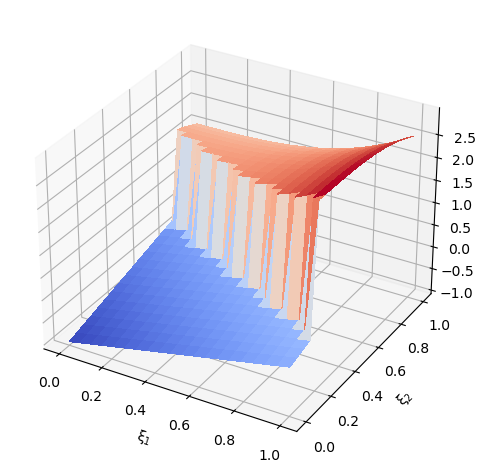

In [20]:
xx = np.linspace(0,1,20)
X1, X2 = np.meshgrid(xx, xx)

F = np.zeros([20,20])

for i in range(20):
    for j in range(20):
        F[i, j] = f(X1[i, j], X2[i, j])
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', xlabel=r'$\xi_1$', ylabel=r'$\xi_2$')
surf = ax.plot_surface(X1, X2, F, linewidth=0, antialiased=False, cmap=cm.coolwarm)  
plt.tight_layout()

This is a standard EasyVVUQ SC campaign, where we prescribe a standard uniform distribution for $x_1$ and $x_2$:

In [35]:
def get_campaign():
    ##################################
    # Define (total) parameter space #
    ##################################

    # Define parameter space
    params = {
        "xi_1": {
            "type": "float",
            "min": 0.0,
            "max": 1.0,
            "default": 0.5},
        "xi_2": {
            "type": "float",
            "min": 0.0,
            "max": 1.0,
            "default": 0.5}}

    ###########################
    # Set up a fresh campaign #
    ###########################

    encoder = uq.encoders.GenericEncoder(
        template_fname= os.path.abspath('discont_model.template'),
        delimiter='$',
        target_filename='input.csv')

    execute = ExecuteLocal('{}/discont_model.py'.format(os.getcwd()))

    output_columns = ["f"]

    decoder = uq.decoders.SimpleCSV(
        target_filename='output.csv',
        output_columns=output_columns)

    actions = Actions(CreateRunDirectory(root='/tmp', flatten=True), Encode(encoder), execute, 
                      Decode(decoder))

    campaign = uq.Campaign(name='standard_SC', work_dir='/tmp', params=params, actions=actions)
    
    return campaign

campaign = get_campaign()

#######################
# Specify input space #
#######################

vary = {
    "xi_1": cp.Uniform(0.0, 1.0),
    "xi_2": cp.Uniform(0.0, 1.0)
}

##################
# Select sampler #
##################

sampler = uq.sampling.SCSampler(vary=vary, polynomial_order=6)

# Associate the sampler with the campaign
campaign.set_sampler(sampler)

###############################
# execute the defined actions #
###############################

campaign.execute().collate()

# get EasyVVUQ data frame
data_frame = campaign.get_collation_result()

############################
# Post-processing analysis #
############################

analysis = uq.analysis.SCAnalysis(sampler=sampler, qoi_cols=["f"])
results = analysis.analyse(data_frame=data_frame)
results.describe()

,f
,0
mean,0.972725
std,1.294315
var,1.675251


The displayed output stats do not immediately hint at a problem. However, when we plot the surrogate $\tilde f$ we find:

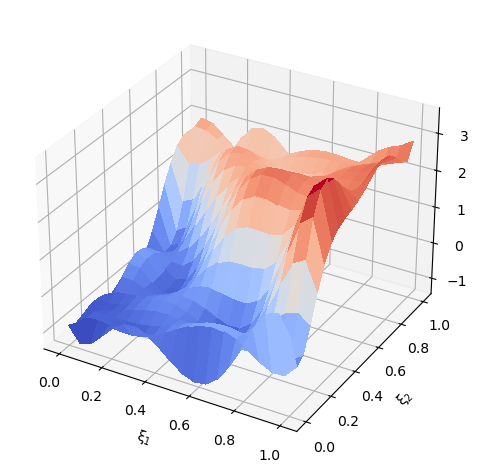

In [36]:
##############################
# Plot the surrogate samples #
##############################
def plot_surrogate(analysis):
    #generate n_mc samples from the input distributions
    N_MC = 20
    xx = np.linspace(0, 1, N_MC)
    X, Y = np.meshgrid(xx, xx)
    F = np.zeros([N_MC, N_MC])

    # evaluate the surrogate at these values
    for i in range(N_MC):
        for j in range(N_MC):
            xi_mc = np.array([X[i, j], Y[i, j]])
            F[i, j] = analysis.surrogate('f', xi_mc)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d', xlabel=r'$\xi_1$', ylabel=r'$\xi_2$')
    surf = ax.plot_surface(X, Y, F, linewidth=0, antialiased=False, cmap=cm.coolwarm)  
    plt.tight_layout()

plot_surrogate(analysis)

Clearly, $\tilde f$ contains many "unphysical" oscillations. This is Runge phenomenon, caused by trying to model a function $f$ with highly **localized & abrupt** changes, by a function $\tilde f$ based on **global & smooth** polynomials. In other words, for this function our choice of interpolation polynomials (the Lagrange polynomials $a_{j_i}(x_i)$ shown above) is not good. A localized polynomial basis is required, that is able to adapt the local behavior of $f$.

## Simplex stochastic collocation 

The Simplex Stochastic Collocation (SSC) method differs from traditional collocation methods (SC/PCE), as it employs the Delaunay triangulation to discretize the probability space into simplex elements, rather than relying on the more common tensor product of one-dimensional abscissas. Using a multi-element technique has the advantage that local mesh adaptation can be performed, such that only regions of interest are refined. Since the SSC method discretizes the parameter space $\Xi$ into $n_e$ disjoint simplices $\Xi = \Xi_1 \cup \cdots \cup \Xi_{n_e}$,
the local surrogate function $w_j$ (for inputs $\boldsymbol\xi\in\Xi_j$) is given by the expansion

\begin{align} 
 w_j(\boldsymbol\xi) = \sum^{N_j}_{l = 0} c_{j,l}\Psi_{j, l}(\boldsymbol\xi).
\end{align}

The $N_j+1$ number of points needed for $d$-dimensional interpolation of polynomial order $p_j$ is given by 

\begin{align} \label{eq:Np1_j}
 N_j + 1 = \frac{(d+p_j)!}{d!p_j!}.
\end{align}

The interpolation basis functions $\Psi_{j, l}$ are simple monomials, and the coefficients $c_{j, l}$ are found by solving a Vandermonde system, see the references below.

The SSC method automatically reduces the
polynomial order if a stencil $S_j$ crosses a discontinuity. It achieves this by
enforcing the so-called **Local Extremum Conserving (LEC)** limiter to all simplices $\Xi_j$ in all $S_j$. The LEC condition is given by

\begin{align}
\boxed{
 \min_{\boldsymbol\xi\in\Xi_j} w_j(\boldsymbol\xi) = \min{\bf v}_j \wedge \max_{\boldsymbol\xi\in\Xi_j}
w_j(\boldsymbol\xi) = \max{\bf v}_j},
\end{align}

where ${\bf v}_j = \{v_{k_{j,0}},\cdots,{v_{k_{j,d}}}\}$ are the code samples at
the vertices of $\Xi_j$. If $w_j$ violates the LEC condition above in one of its
$\Xi_j\in S_j$, the polynomial order $p_j$ of that stencil is reduced, usually
by 1. Since polynomial
overshoots occur when trying to interpolate a discontinuity, $p_j$ is reduced
the most in discontinuous regions. Interpolating a function on a simplex with
$p_j = 1$ and ${\bf v}_j$ located at its vertices always satisfies
the LEC condition. This ensures that $w(\boldsymbol\xi)$ is
able to represent discontinuities without suffering from the Runge phenomenon.
In practice, the LEC condition is enforced for all $\Xi_j $ in all $S_j$ via random
sampling of the $w_j$. If for a given $w_j$ the LEC condition is violated for any of the randomly placed
samples $\boldsymbol\xi_j$, the polynomial order of the corresponding stencil is reduced. 

Which $N_j+1$ points are used for $w_j$ is determined by the interpolation stencil $S_j$. The stencil can be constructed based on the nearest-neighbour principle. In this case the first $d+1$ points are the vertices 
$\{\boldsymbol\xi_{k_{j,0}},\cdots,\boldsymbol\xi_{k_{j,d}}\}$ of the simplex $\Xi_j$, which would suffice for $p_j = 1$. For higher degree interpolation, neighbouring points $\boldsymbol\xi_k$ are added based on their proximity to the center of simplex
$\Xi_j$, i.e. based on their ranking according to

\begin{align} \label{eq:center_j}
 \Vert \boldsymbol\xi_k - \boldsymbol\xi_{\mathrm{center},j} \rVert_2,
\end{align}

where those $\boldsymbol\xi_k$ of the current simplex $\Xi_j$ are excluded.
The simplex center $\boldsymbol\xi_{\mathrm{center},j}$ is defined as

\begin{align}
  \boldsymbol\xi_{\mathrm{center},j} := \frac{1}{d+1}\sum^{d}_{l = 0}\boldsymbol\xi_{k_{j,l}}.
\end{align}

The nearest neighbor stencil leads to a $p_j$
distribution that can increase quite slowly when moving away from a
discontinuity. An example of this behavior can be found in the figure
below, which shows the Delaunay triangulation with a discontinuity
running through the domain (dotted line). An alternative to nearest-neighbor
stencils are stencils created according to the **Essentially Non-Oscillatory (ENO)**
principle [1]. The idea behind ENO stencils is to have
higher degree interpolation stencils up to a thin layer of simplices containing
the discontinuity. For a given simplex $\Xi_j$, its ENO stencil is created by
locating all the nearest-neighbor stencils that contain $\Xi_j$, and
subsequently selecting the one with the highest $p_j$. This leads to a Delaunay
triangulation which captures the discontinuity better than its nearest-neighbor
counterpart.

![](./images/NN_ENO.png)

Like dimension-adaptive sampling, the SSC method iteratively refines the sampling plan. Which simplex element is refined is based on a geometrical refinement measure, given by;

\begin{align} \label{eq:ref_meas}
 \bar{e}_j := \bar{\Omega}_j\bar{\Xi}_j^{2O_j}.
\end{align}

It contains the probability and the volume of simplex $\Xi_j$, i.e.

\begin{align} \label{eq:prob_and_vol}
 \bar{\Omega}_j =
\int\limits_{\Xi_j}f_{\boldsymbol\xi}(\boldsymbol\xi)d\boldsymbol\xi\;\;\;\mathrm{and}\;\;\;
 \bar{\Xi}_j = \int\limits_{\Xi_j}d\boldsymbol\xi,
\end{align}
where $\bar{\Xi} = \sum^{n_e}_{j=1}\bar{\Xi}_j$. The probability $\bar{\Omega}_j$ can be computed by Monte-Carlo sampling and $\bar{\Xi}_j$ via the relation

\begin{align} \label{eq:vol_j}
 \bar{\Xi}_j = \frac{1}{d!}\lvert\mathrm{det}\left(D\right)\rvert,\;\;\;D =
\left[\boldsymbol\xi_{k_{j,1}}-\boldsymbol\xi_{k_{j,0}}\;\;\;\;\boldsymbol\xi_{k_{j,2}}-\boldsymbol\xi_{k_{j,0}}
\;\;\;\;\cdots\;\;\;\; \boldsymbol\xi_{k_{j,d+1}}-\boldsymbol\xi_{k_{j,0}}\right]
\in\mathbb{R}^{d \times d}.
\end{align}

Finally, the order of convergence $O_j$ is given by

\begin{align} \label{eq:order_conv}
 O_j = \frac{p_j+1}{d}.
\end{align}

The simplex with the highest $\bar{e}_j$ is selected for refinement. To ensure a good spread of the sample points, only randomly-selected points inside a simplex sub-element $\Xi_{sub_j}$ are allowed. The vertices of this sub-element are defined as

\begin{align} \label{eq:sub_simplex}
 \boldsymbol\xi_{sub_{j,l}} := \frac{1}{d}\sum^{d}_{\substack{l^*=0 \\ l^*\neq l}}
\boldsymbol\xi_{k_{j,l^*}},
\end{align}

see Figure below for a two-dimensional example. The SSC algorithm can be parallelized by selecting the $N<n_e$ simplices with the $N$ largest $\bar{e}_j$ for refinement. 

Note that $\bar{e}_j$ is probabilistically weighted through $\Omega_j$ and that it assigns
high value to those simplices with low $p_j$ since in general $\bar{\Xi}_j\ll1$. Effectively this means that
$\bar{e}_j$ is a solution-dependent refinement measure which refines simplices near discontinuities since the SSC method automatically reduces the polynomial order (via LEC) if a stencil $S_j$ crosses a discontinuity.

This is the overall overview of the SSC method. For more information consult the articles below and the references therein.

**References**

[1] Witteveen, J. A. S., & Iaccarino, G. (2013). Simplex stochastic collocation with ENO-type stencil selection for robust uncertainty quantification. Journal of Computational Physics, 239, 1-21.

[2] Edeling, W. N., Dwight, R. P., & Cinnella, P. (2016). Simplex-stochastic collocation method with improved scalability. Journal of Computational Physics, 310, 301-328.

## Simplex Stochastic Collocation on a discontinuous function

We generate the EasyVVUQ campaign in the exact same way as in the SC case;

In [23]:
campaign = get_campaign()

Selecting the SSC sampler is also very similar to the SC case;

In [24]:
##################
# Select sampler #
##################

sampler = uq.sampling.SSCSampler(vary=vary, max_polynomial_order=4)

# Associate the sampler with the campaign
campaign.set_sampler(sampler)

Here, `max_polynomial_order = 4` limits the maximum polynomial order of the individual interpolation stencils to 4. 

Now we run all actions in the defined `actions` object, including running the code on the initial sampling plan:

In [25]:
###############################
# execute the defined actions #
###############################

campaign.execute().collate()

Now we set the following flags;

In [26]:
# number of samples used in the LEC check 
n_mc_LEC = 50

# max number of LEC evaluations that can be run in parallel
max_LEC_jobs = 2

# max number of functions evaluations that can be run in parallel
max_fjobs = 4

Here;

* `n_mc_LEC = 50`: sets the number of times *each* local surrogate $w_j$ is evaluated in the LEC check to 50, with $j=1,\cdots,n_e$. Here $n_e$ is the number of simplex elements.

* `max_LEC_jobs = 2`: sets the number of LEC evaluations that are done in parallel to 4. Each simplex element can be given the LEC check independent of the others. The [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) library is used for this.

* `max_fjobs = 4`: sets the number of new code evaluations per iteration of the SSC algorithm to 4. This means that the 4 simplex elements with the largest refinement metric $\bar{e}_j$ will get refined. The `max_f_jobs` code evaluations can be done in parallel, and on supercomputers, using the VECMA/SEAVEA tools [FabSim3](https://github.com/djgroen/FabSim3) (see [this recent article](https://www.sciencedirect.com/science/article/pii/S0010465522003150) for a detailed overview of FabSim3) or [QCG-PilotJob](https://easyvvuq.readthedocs.io/en/nbsphinx/notebooks/easyvvuq_qcgpj_tutorial.html). In this tutorial the executing will be done sequentially on the localhost.

To refine the sampling plan, we need an `SSCAnalysis` object:

In [27]:
analysis = uq.analysis.SSCAnalysis(sampler = sampler, qoi_cols=['f'])

Here we update the surrogate (i.e. check the LEC condition and compute the ENO stencils), using the initial code samples (contained in the `data_frame`):

Loading samples...
done
Max. polynomial order allowed by n_s = 1
Checking LEC condition of 4 stencils...
done.
Computing ENO stencils...
done.
Updated polynomials orders = [1 1 1 1]
Computing simplex probabilities...
done, used 100000 samples.
% of simplices with no samples = 0.0


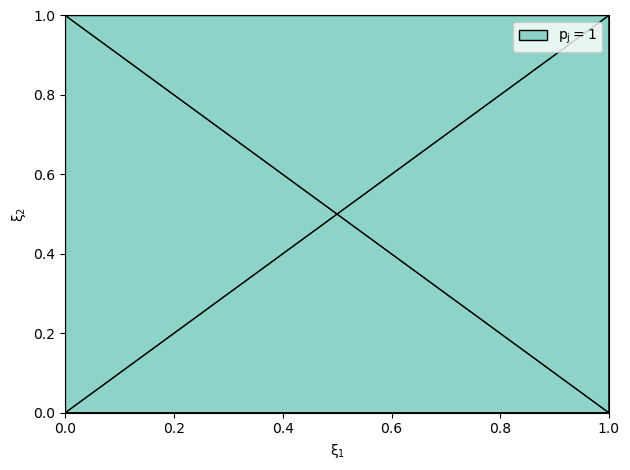

In [28]:
# get code samples
data_frame = campaign.get_collation_result()
# update surrogate by checking LEC condition and computing ENO stencils
analysis.update_surrogate('f', data_frame, n_mc_LEC=n_mc_LEC)
# plot the sampling plan
analysis.plot_2D_triangulation()

This shows the initial sampling plan, consisting of 4 simplices ($n_e = 4$) and 5 code samples ($n_s=5$). The code samples are located at the points of the simplices, Hence the initial sampling plan is created by placing one code sample in the middle, and one on each corner of the hypercube (in this case the square). Hence in the case of $n_\xi$ random inputs, the number of initial code samples is given by:

\begin{align*}
n_s = 2^{n_\xi} + 1
\end{align*}

The exponential increase the number of (initial) code samples is already an indication that the curse of dimensionality is present in the SSC method. As such, this method does not scale well to high $n_xi$. Means to extend it to higher dimensions are discussed in reference [2] above.

For now, we stick with $n_\xi=2$. Note from the figure above that all elements are linear ($p_j=1$), since $n_s=5$ is not suffient to build higher-order interpolation stencils in 2D. Let us now execute our first refinement iteration:

In [29]:
def refine(campaign, analysis, n_refinements, max_fjobs, n_mc_LEC):
    """
    Refine the SSC sampling plan with max_fjobs new samples.

    Parameters
    ----------
    campaign : easyvvuq.campaign.Campaign
        The EasyVVUQ campaign of the SSC sampler.
    analysis : easyvvuq.analysis.ssc_analysis.SSCAnalysis
        The SSC analysis object, used to refine the sampling plan.
    n_refinements : int
        The number of refinement iterations.
    max_fjobs : int
        The number of new code evaluations per refinement iteration.
    n_mc_LEC : int
        The number of surrogate Monte Carlo samples used in the LEC check.

    Returns
    -------
    None.

    """
    for i in range(n_refinements):
        # get code samples
        data_frame = campaign.get_collation_result()
        # update surrogate by checking LEC condition and computing ENO stencils
        analysis.update_surrogate('f', data_frame, n_mc_LEC=n_mc_LEC)
        # refine the max_jobs simplices with the highest refinement measure
        analysis.adapt_locally(max_fjobs)
        # run the new code samples
        campaign.execute().collate()

    # do not forget to update the surrogate after the last code evaluations
    data_frame = campaign.get_collation_result()
    analysis.update_surrogate('f', data_frame)

Loading samples...
done
Max. polynomial order allowed by n_s = 1
Checking LEC condition of 4 stencils...
done.
Computing ENO stencils...
done.
Updated polynomials orders = [1 1 1 1]
Computing simplex probabilities...
done, used 100000 samples.
% of simplices with no samples = 0.0
refining edge
refining edge
refining edge
refining edge
Loading samples...
done
Max. polynomial order allowed by n_s = 2
Checking LEC condition of 8 stencils...
done.
Computing ENO stencils...
done.
Updated polynomials orders = [1 1 2 2 2 2 2 2]
Computing simplex probabilities...
done, used 100000 samples.
% of simplices with no samples = 0.0


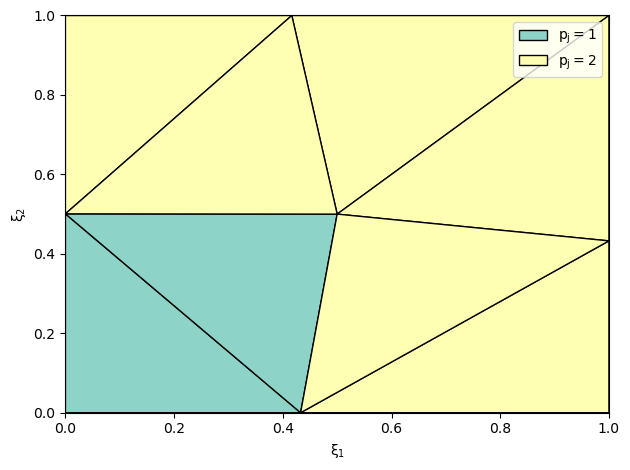

In [30]:
# fix random seed
# np.random.seed(42)
# refine the sampling plan once
refine(campaign, analysis, 1, max_fjobs, n_mc_LEC)
analysis.plot_2D_triangulation()

We can see that new code samples have been added, and that some simplices now have quadratic interpolation stencils, unless the LEC check reduced them back to 1. The refinement within the subsimplex is random, so if you rerun the analysis you will not get the exact same sampling plan, unless the random seed is fixed (uncomment the `np.random.seed` line above).

Let us now run several consecutive refinements:

In [31]:
refine(campaign, analysis, 15, max_fjobs, n_mc_LEC)

Loading samples...
done
Max. polynomial order allowed by n_s = 2
Checking LEC condition of 8 stencils...
done.
Computing ENO stencils...
done.
Updated polynomials orders = [1 1 2 2 2 1 1 1]
Computing simplex probabilities...
done, used 100000 samples.
% of simplices with no samples = 0.0
refining edge
refining edge
Loading samples...
done
Max. polynomial order allowed by n_s = 3
Checking LEC condition of 16 stencils...
done.
Computing ENO stencils...
done.
Updated polynomials orders = [1 1 2 2 2 1 1 1 1 1 2 1 2 2 2 2]
Computing simplex probabilities...
done, used 100000 samples.
% of simplices with no samples = 0.0
refining edge
refining edge
refining edge
Loading samples...
done
Max. polynomial order allowed by n_s = 4
Checking LEC condition of 22 stencils...
done.
Computing ENO stencils...
done.
Updated polynomials orders = [2 2 1 1 1 2 1 1 2 2 2 2 2 2 2 2 2 2 1 1 1 1]
Computing simplex probabilities...
done, used 100000 samples.
% of simplices with no samples = 0.0
refining edge
Loa

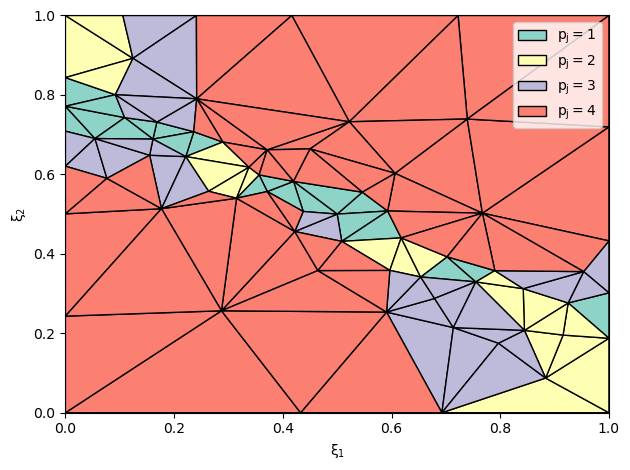

In [32]:
analysis.plot_2D_triangulation()

Where the discontinuity lies should now be clear through a relatively thin line of simplices with $p_j=1$ or $p_j=2$. Simplices with higher 4-th order interpolations stencils should appear away from the discontinutity, where the function is smooth.

We now plot the SSC surrogate;

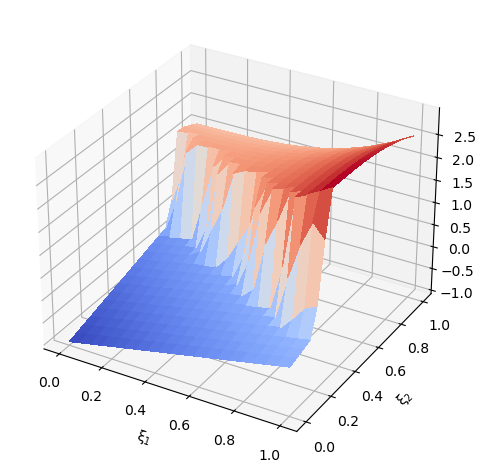

In [33]:
plot_surrogate(analysis)

This should now be a much better approximation to the real function than the SC surrogate, free of the Runge phenomenom. 

We can now compute the mean and variance with confidence. The SSC method uses simple Monte Carlo to compute these:

In [34]:
campaign.apply_analysis(analysis)
results = campaign.get_last_analysis()
results.describe()

Loading samples...
done
Computing mean and variance...
done.


,f
,0
mean,0.910000
std,1.256884
var,1.579756
